# 19. Calibrate Dashcam

Create a model to compensate for optical distortion in the dash camera being used for the following experiments, as per a standard OpenCV process documented here:

https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html

https://medium.com/vacatronics/3-ways-to-calibrate-your-camera-using-opencv-and-python-395528a51615

https://towardsdatascience.com/computer-vision-for-lane-finding-24ea77f25209

The process is designed to correct for distortion whereby straight lines appear curved in the original image.  It does not appear to be necessary to correct for this when training and using a model to detect bicycle lane markings:  The deep learning model will learn what the marking might look like from different angles and at different positions in the frame.  But if we are going to try to detect lane markings on the road -- which are often straight -- for the purposes of detecting paved shoulders, then it "couldn't hurt" to help the process by removing the distortion.  Further research could be conducted determing the impact of applying this correction, or not, but that is considered outside the scope of this research project.  Some previous examples of applying Canny/Hough lane detection techniques corrected for this optical distortion.  And it seemed like it would be very useful to have for any future research where we are estimating the actual width of lanes.

The first link contains an image file that should be printed to piece of paper and displayed in front of the dashcam to capture the required images.  The direct link:

https://docs.opencv.org/2.4/_downloads/pattern.png

## Configuration

Any configuration that is required to run this notebook can be customized in the next cell

In [1]:
# Directory where calibration footage is found, and where images will be extracted
# This directdory is expected to be found within the 'data_sources' directory
calibration_footage_dir = 'dashcam_calibration_images'

# Characteristics of the calibration pattern that was printed and displayed in the calibration footage
square_size   = 2.52   # size of squares on the test image in centimetres
width         = 9      # width of the pattern, in square intersection vertices
height        = 6      # height of the pattern, in square intersection vertices

# If the pattern is 10 squares by 7 squares, as per the "pattern.png" linked above,
# then we have 9 points of intersection betwen the squares in one dimension (10-1),
# and 6 in the other (7-1).  Don't forget to hold the paper the correct way compared
# to the "width" and "height" you have quoted!

# The name of the file where we will write the calibration model, to be
# applied later to correct images from the dashcam footage.
# This will be written to the 'data_sources' directory.
output_calibration_filename = 'dashcam_calibration.yml'

## Code

In [2]:
# General imports

import os
import sys
import cv2
import numpy as np
import pathlib

from datetime import datetime

import matplotlib.pylab as plt

%matplotlib inline

module_path_root = os.path.abspath(os.pardir)
if module_path_root not in sys.path:
    sys.path.append(module_path_root)

In [3]:
# Derived paths

# Path to directory where calibration footage is loaded, and calibration images are saved
calibration_footage_path = os.path.join(module_path_root, 'data_sources', calibration_footage_dir)

# Full path to where the output calibration model will be written
output_calibration_path = os.path.join(module_path_root, 'data_sources', output_calibration_filename)

## Code

The first three function definitions:

* calibrate_chessboard
* save_coefficients
* load_coefficients

Are taken from the tutorial at: https://medium.com/vacatronics/3-ways-to-calibrate-your-camera-using-opencv-and-python-395528a51615

Which is probably adapted to Python from official OpenCV C++ tutorial code at: https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html

In [4]:
def calibrate_chessboard(dir_path, image_format, square_size, width, height):
    '''Calibrate a camera using chessboard images.'''
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    print(dir_path)
    images = pathlib.Path(dir_path).glob(f'*.{image_format}')
    # Iterate through all images
    
    for idx, fname in enumerate(images):
        print('{0:s} Processing image # {1:d} {2:s}'.format(str(datetime.now()), idx, str(fname)))
        
        img = cv2.imread(str(fname))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]

def save_coefficients(mtx, dist, path):
    '''Save the camera matrix and the distortion coefficients to given path/file.'''
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write('K', mtx)
    cv_file.write('D', dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()

def load_coefficients(path):
    '''Loads camera matrix and distortion coefficients.'''
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode('K').mat()
    dist_matrix = cv_file.getNode('D').mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

## Convert calibration video to images

In [5]:
# Function to split an MP4 video file into images in an output directory
# Frames will only be output at a certain interval
# e.g. interval=5 will only output every 5th frame
# Because we don't need 60fps!  We only need a few dozen images where
# the calibration tool has been held in front of the camera in a variety
# of positions across the frame.
def split_video(filename, output_dir, video_num, interval):
    cap = cv2.VideoCapture(filename)
    
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    frame_num = 0
    
    while True:
        ret, frame = cap.read()
        frame_num += 1
        
        if ret == True:
            if frame_num % interval == 0:
                filename = 'frame_{0:02d}_{1:05d}.png'.format(video_num, frame_num)
                print('Writing: {0:s}'.format(filename))
                cv2.imwrite(os.path.join(output_dir, filename), frame)
        else:
            break
    
    cap.release()        

In [7]:
# In our experiment, we took two videos.  The second video was taken after reviewing the first,
# to ensure that there was adequate coverage holding the calibration tool at different positions
# in the frame and at different distances.

# Define the paths to the two videos
video1 = os.path.join(calibration_footage_path, 'distortion_calibration1.mp4')
video2 = os.path.join(calibration_footage_path, 'distortion_calibration2.mp4')

# Split the two videos into PNG images, one frame per second (interval=60)
split_video(video1, calibration_footage_path, 1, 60)
split_video(video2, calibration_footage_path, 2, 60)

Writing: frame_01_00060.png
Writing: frame_01_00120.png
Writing: frame_01_00180.png
Writing: frame_01_00240.png
Writing: frame_01_00300.png
Writing: frame_01_00360.png
Writing: frame_01_00420.png
Writing: frame_01_00480.png
Writing: frame_01_00540.png
Writing: frame_01_00600.png
Writing: frame_01_00660.png
Writing: frame_01_00720.png
Writing: frame_01_00780.png
Writing: frame_01_00840.png
Writing: frame_01_00900.png
Writing: frame_01_00960.png
Writing: frame_01_01020.png
Writing: frame_01_01080.png
Writing: frame_01_01140.png
Writing: frame_01_01200.png
Writing: frame_01_01260.png
Writing: frame_01_01320.png
Writing: frame_01_01380.png
Writing: frame_01_01440.png
Writing: frame_01_01500.png
Writing: frame_01_01560.png
Writing: frame_01_01620.png
Writing: frame_01_01680.png
Writing: frame_01_01740.png
Writing: frame_01_01800.png
Writing: frame_01_01860.png
Writing: frame_01_01920.png
Writing: frame_01_01980.png
Writing: frame_01_02040.png
Writing: frame_01_02100.png
Writing: frame_01_02

In [8]:
# Generate the model parameters from the images
# This step may take a while, maybe 10-20 seconds per image on my system
ret, mtx, dist, rvecs, tvecs = calibrate_chessboard(calibration_footage_path, 'png', square_size, width, height)

# Save the necessary model parameters to the output configuration file
save_coefficients(mtx, dist, output_calibration_path)

E:\Release\minor_thesis\data_sources\dashcam_calibration_images
2021-10-09 12:52:55.653370 Processing image # 0 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00060.png
2021-10-09 12:53:10.728580 Processing image # 1 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00120.png
2021-10-09 12:53:24.471282 Processing image # 2 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00180.png
2021-10-09 12:53:38.392511 Processing image # 3 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00240.png
2021-10-09 12:53:51.987868 Processing image # 4 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00300.png
2021-10-09 12:54:05.393283 Processing image # 5 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00360.png
2021-10-09 12:54:19.105199 Processing image # 6 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_01_00420.png
2021-10-09 12:54:32

2021-10-09 13:02:30.285640 Processing image # 62 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00180.png
2021-10-09 13:02:44.884407 Processing image # 63 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00240.png
2021-10-09 13:02:59.738116 Processing image # 64 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00300.png
2021-10-09 13:03:14.623098 Processing image # 65 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00360.png
2021-10-09 13:03:29.633023 Processing image # 66 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00420.png
2021-10-09 13:03:43.671309 Processing image # 67 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00480.png
2021-10-09 13:03:58.671834 Processing image # 68 E:\Release\minor_thesis\data_sources\dashcam_calibration_images\frame_02_00540.png
2021-10-09 13:04:13.562246 Processing image # 69 E:\Release\minor_thesis\dat

## Demo

Process a demonstration image from the dash camera

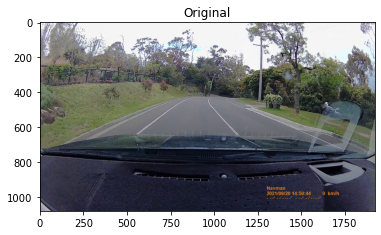

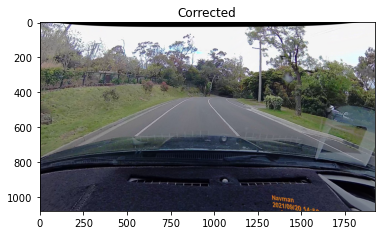

In [11]:
# Specify path to an example image (from GitHub)
sample_image_path  = os.path.join(module_path_root, 'data_sources', 'dashcam_samples', 'frame_01_02160.png')

# Load the distortion model for the corresponding camera (from GitHub)
mtx, dist = load_coefficients(os.path.join(module_path_root, 'data_sources', 'dashcam_calibration.yml'))

# Load the original image
original = cv2.imread(sample_image_path)

# Create a version of the image where a transformation has been applied to compensate for optimcal distortion
corrected = cv2.undistort(original, mtx, dist, None, None)

# Display the original and corrected images
# (taking into account color space)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
plt.title('Corrected')
plt.show()